<a href="https://colab.research.google.com/github/Axis121/AMLS_Project/blob/main/Emotion_Detector_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#https://towardsdatascience.com/basic-smile-detection-using-opencv-and-dlib-aeb22afb9e67


In [12]:
import cv2
import dlib
from google.colab.patches import cv2_imshow
#https://stackoverflow.com/questions/3426108/how-to-sort-a-list-of-strings-numerically
from natsort import natsorted # pip install natsort
import os
from os import listdir
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [13]:
def faceLandmarks(im):

    # Path for the detection model, you can download it from here: https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat
    PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"
    
    # Create object to detect the face
    faceDetector = dlib.get_frontal_face_detector()

    # Create object to detect the facial landmarks
    landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces
    faceRects = faceDetector(im, 0)

    # Initialize landmarksAll array
    landmarksAll = []

    # For each face detected in the image, this chunk of code creates a ROI around the face and pass it as an argument to the 
    # facial landmark detector and append the result to the array landmarks 
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        landmarks = landmarkDetector(im, newRect)
        landmarksAll.append(landmarks)

    return landmarksAll, faceRects


In [14]:
def renderFacialLandmarks(im, landmarks):
    
    # Convert landmarks into iteratable array
    points = []
    [points.append((p.x, p.y)) for p in landmarks.parts()]

    # Loop through array and draw a circle for each landmark
    for p in points:
        cv2.circle(im, (int(p[0]),int(p[1])), 2, (255,0,0),-1)

    # Return image with facial landmarks 
    return im

Extractions of features

In [15]:
def extractFeatures(folder_dir): 
    number_of_features = 136 #68 coordinates, x and y points
    features = np.ones((1,number_of_features))*10
    current_features = np.zeros((1,number_of_features))

    for images in natsorted(os.listdir(folder_dir)):
    
        # check if the image ends with png
        if (images.endswith(".jpg")):
            
            print(images) # for testing
            #type(images)
            ##use images to finish the directory call for im
            ## Read an image to a variable
            im = cv2.imread(folder_dir +"/" + images)
            
            # Get landmarks using the function created above
            landmarks, _ = faceLandmarks(im)

            if len(landmarks) == 0: #set features to 0
                for j in range(68):
                  current_features [0,j]=0
                  current_features [0,j+68]=0

            else:
                # Render the landmarks on the first face detected. You can specify the face by passing the desired index to the landmarks array.
                # In this case, one face was detected, so I'm passing landmarks[0] as the argument.
                faceWithLandmarks = renderFacialLandmarks(im, landmarks[0])
                for j in range(68):
                  #print(j)
                  current_features [0,j]=landmarks[0].parts()[0].x-landmarks[0].parts()[j].x
                  current_features [0,j+68]=landmarks[0].parts()[0].y-landmarks[0].parts()[j].y
        features = np.vstack((features,current_features))
    
    features = np.delete(features,0,axis = 0)
    return features
    print("done")
            

In [34]:
def getSelectedFacialFeatures(features): # derive the specific features from the landmark coordinates
  rows, cols = features.shape
  number_of_features = 18
  x = features [:,:68] # extract x coordinates from features matrix
  y = features [:,-68:] # extract y coordinates from features matrix

  selected_features = np.zeros((rows,number_of_features))

  # lip width
  selected_features [:,0] = x[:,48] - x[:,54]

  # jaw width
  selected_features [:,1] = x[:,2] - x[:,14]

  # ratio of lip and jaw width
  selected_features [:,2] = selected_features [:,0]/selected_features [:,1]

  # MAR (Mouth Aspect Ratio) (a1 + a2)/(2*a3)
  a1 = y[:,50] - y[:,58]
  a2 = y[:,51] - y[:,57]
  a3 = y[:,52] - y[:,56]
  a4 = x[:,48] - x[:,54]

  selected_features [:,3] = (a1+a2+a3)/(3*a4) 

  # Cheek puffiness
  selected_features [:,4] = y[:,11] - y[:,30]

  # lip curvature ## check formula
  selected_features [:,5] = y[:,60] - y[:,66]

  # Mouth corners
  selected_features [:,6] = x[:,48]
  selected_features [:,7] = y[:,48]

  selected_features [:,8] = x[:,54]
  selected_features [:,9] = y[:,54]

  # eye corners

  selected_features [:,10] = x[:,16]
  selected_features [:,11] = y[:,16]

  selected_features [:,12] = x[:,20]
  selected_features [:,13] = y[:,20]

  selected_features [:,14] = x[:,21]
  selected_features [:,15] = y[:,21]

  selected_features [:,16] = x[:,25]
  selected_features [:,17] = y[:,25]

  return abs(selected_features)

In [16]:
def getLabel(label_dir,column):
  df = pd.read_csv(label_dir)
  #df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test_folder/dataset/labels_modified.csv')
  #df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/labels_modified.csv')
  #print(df.iloc[:,3].values)


  # replace() syntax
  df = df.replace(-1,0)
  labels = df.iloc[:,column].values #face shape is the 3rd coloumn, eye colour is the 2nd
  labels = np.transpose(labels)

  return labels

In [54]:
def removeMissingValues (features, labels):

  rows, cols = features.shape
  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally
  featuresAndLabels = featuresAndLabels[~np.all(featuresAndLabels[:,:136] == 0, axis=1)] #remove rows if the feature row section is full of zeroes
  featuresAndLabels = featuresAndLabels[~np.any(np.isnan(featuresAndLabels[:,:136])==True, axis=1)] #remove rows if the feature row section is full of zeroes
  featuresAndLabels = featuresAndLabels[~np.any(np.isinf(featuresAndLabels[:,:136])==True, axis=1)] #remove rows if the feature row section is full of zeroes


  clean_features = featuresAndLabels [:,:cols] # remake feature matrix
  clean_labels = featuresAndLabels [:,-1] # remake label vector

  return clean_features, clean_labels

In [18]:
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/img" # training set
#folder_dir = "//content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/celeba_test/img" # test set

features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/CelebA_feature_set.npy",features)

0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
30.jpg
31.jpg
32.jpg
33.jpg
34.jpg
35.jpg
36.jpg
37.jpg
38.jpg
39.jpg
40.jpg
41.jpg
42.jpg
43.jpg
44.jpg
45.jpg
46.jpg
47.jpg
48.jpg
49.jpg
50.jpg
51.jpg
52.jpg
53.jpg
54.jpg
55.jpg
56.jpg
57.jpg
58.jpg
59.jpg
60.jpg
61.jpg
62.jpg
63.jpg
64.jpg
65.jpg
66.jpg
67.jpg
68.jpg
69.jpg
70.jpg
71.jpg
72.jpg
73.jpg
74.jpg
75.jpg
76.jpg
77.jpg
78.jpg
79.jpg
80.jpg
81.jpg
82.jpg
83.jpg
84.jpg
85.jpg
86.jpg
87.jpg
88.jpg
89.jpg
90.jpg
91.jpg
92.jpg
93.jpg
94.jpg
95.jpg
96.jpg
97.jpg
98.jpg
99.jpg
100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
105.jpg
106.jpg
107.jpg
108.jpg
109.jpg
110.jpg
111.jpg
112.jpg
113.jpg
114.jpg
115.jpg
116.jpg
117.jpg
118.jpg
119.jpg
120.jpg
121.jpg
122.jpg
123.jpg
124.jpg
125.jpg
126.jpg
127.jpg
128.jpg
129.jpg
130.jpg
131.jpg
132.jpg
133.jpg
134.jpg
135.jpg
136.jpg
137.jpg
138.jp

Loading saved features and importing labels

In [19]:
features = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/CelebA_feature_set.npy")

In [62]:
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/labels_modified.csv' # training set labels
#label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/modified_labels.csv' # test set labels

labels = getLabel(label_dir,column = 3) # get label vector #gender is the 3rd column, smile is the 4th

In [31]:
print(labels)

[1 1 0 ... 1 1 1]


Processing Data

In [63]:
# get selected facial features
selected_features = getSelectedFacialFeatures (features)
#remove rows with missing values
clean_features, clean_labels = removeMissingValues (selected_features, labels)

<ipython-input-34-578153b0acec>:16: RuntimeWarning: invalid value encountered in true_divide
  selected_features [:,2] = selected_features [:,0]/selected_features [:,1]
<ipython-input-34-578153b0acec>:24: RuntimeWarning: invalid value encountered in true_divide
  selected_features [:,3] = (a1+a2+a3)/(3*a4)


In [64]:
print(clean_features.shape)
print(clean_labels.shape)

(4868, 18)
(4868,)


Graph features and lables

In [ ]:
# Scatterplot - Color Change
x = np.random.randn(50)
y1 = np.random.randn(50)
y2= np.random.randn(50)

# Plot
plt.scatter(x,y1,color='blue')
plt.scatter(x,y2,color= 'red')
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

# Decorate
plt.title('Color Change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

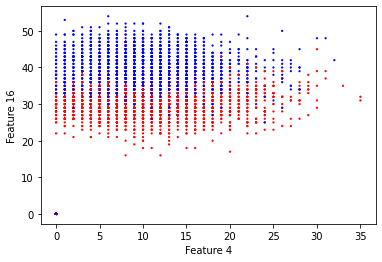

In [44]:
col = np.where(clean_labels>0,'b','r')

feature_norm = clean_features / clean_features.max(axis=0)

plt.scatter(clean_features[:,15], clean_features[:,0], c=col, s=5, linewidth=0)
plt.xlabel("Feature 4")
plt.ylabel("Feature 16")
plt.show()
# 1,6
# 0 1
# 15 0

Obtain training and validation sets from feature selected dataset

In [65]:
from sklearn.model_selection import train_test_split
# train test split is used to produce train and validate sets
X_train, X_validate, Y_train, Y_validate = train_test_split(clean_features, clean_labels, test_size=0.3,random_state=109) # 70% training and 30% test

Obtain test set from separate directory of images

In [ ]:
##make a check to see if load file exists then reload, if it does not exist then extract.

In [ ]:
## Extract Features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/celeba_test/img" # test set
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/celebA_feature_test_set.npy",features) # saving features to a file

In [ ]:
## reload features from saved file and get labels
features_test = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/B1/cartoon_feature_test_set.npy")

## labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/cartoon_set_test/modified_labels.csv' # test set labels
labels_test = getLabel(label_dir, column = ) # get label vector #face shape is the 3rd column, eye colour is the 2nd

In [ ]:
features_test.shape

(2500, 136)

Process Test Data

In [ ]:
## get selected features

## remove missing values
clean_features_test, clean_labels_test = removeMissingValues (features_test, labels_test)

## Match naming convention
X_test = selected_features_test
Y_test = clean_labels_test

In [ ]:
Y_test.shape
X_test.shape

(1979, 30)

Training and Validation of models

In [66]:
#logistic regression model
logr_model = LogisticRegression().fit(X_train, Y_train)
preds = logr_model.predict(X_validate)
print(metrics.classification_report(preds, Y_validate))
metrics.confusion_matrix(Y_validate,preds)

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.75       757
         1.0       0.73      0.74      0.73       704

    accuracy                           0.74      1461
   macro avg       0.74      0.74      0.74      1461
weighted avg       0.74      0.74      0.74      1461



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[562, 185],
       [195, 519]])

In [ ]:
## Tuning hyper parameters of svm rbf model using validation set
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# normalise validation features data
#X_test_normalised = X_validate / X_validate.max(axis=0)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, Y_train)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.209 total time=   8.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.209 total time=   3.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.209 total time=   3.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.209 total time=   3.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.209 total time=   3.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.209 total time=   3.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.209 total time=   3.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.209 total time=   3.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.209 total time=   4.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.209 total time=   3.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.216 total time=   3.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [ ]:
## Validation
grid_predictions = grid.predict(X_validate)

# print classification report
print(metrics.classification_report(Y_validate, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.22      0.20      0.21       462
         1.0       0.25      0.18      0.21       497
         2.0       0.21      0.17      0.19       457
         3.0       0.34      0.41      0.38       503
         4.0       0.36      0.48      0.41       477

    accuracy                           0.29      2396
   macro avg       0.28      0.29      0.28      2396
weighted avg       0.28      0.29      0.28      2396



In [ ]:
## training tuned model based on training set
## features are max normalised
from sklearn import svm
#feaature should be normalised first
X_validate_normalised = X_validate / X_validate.max(axis=0)
X_train_normalised = X_train / X_train.max(axis=0)

#Create a svm Classifier
rbf_svm_model = svm.SVC(decision_function_shape='ovo',kernel='rbf',C=100, gamma=0.0001) #

#Train the model using the training sets
rbf_svm_model.fit(X_train, Y_train)

#Predict the response for validation dataset
y_pred = rbf_svm_model.predict(X_validate)

print(metrics.classification_report(y_pred, Y_validate))
metrics.confusion_matrix(Y_validate,y_pred)

              precision    recall  f1-score   support

         0.0       0.20      0.22      0.21       431
         1.0       0.18      0.25      0.21       364
         2.0       0.17      0.21      0.19       360
         3.0       0.41      0.34      0.38       604
         4.0       0.48      0.36      0.41       637

    accuracy                           0.29      2396
   macro avg       0.29      0.28      0.28      2396
weighted avg       0.32      0.29      0.30      2396



array([[ 94,  85,  75,  78, 130],
       [ 94,  91,  64, 149,  99],
       [ 77,  82,  77, 117, 104],
       [ 73,  70,  76, 208,  76],
       [ 93,  36,  68,  52, 228]])

In [ ]:
#Predict the response for test dataset
y_pred = rbf_svm_model.predict(X_test)

print(metrics.classification_report(y_pred, Y_test))
metrics.confusion_matrix(Y_test,y_pred)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.05      0.19      0.08       107
         2.0       0.94      0.20      0.34      1869
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         3

    accuracy                           0.20      1979
   macro avg       0.20      0.08      0.08      1979
weighted avg       0.89      0.20      0.32      1979



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,  22, 374,   0,   2],
       [  0,  20, 377,   0,   0],
       [  0,  25, 382,   0,   0],
       [  0,  16, 380,   0,   1],
       [  0,  24, 356,   0,   0]])

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

Save the model to be reloaded later

In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = 'B1_svm_model.sav'
pickle.dump(rbf_svm_model, open(filename, 'wb'))

In [ ]:
# load the model from disk
filename = 'B1_svm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
## Test loaded model
result = loaded_model.score(X_test, Y_test)
print(result)

Examination of Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

estimator = svm.SVC(decision_function_shape='ovo',kernel='rbf',C=100, gamma=0.0001)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, selected_features, clean_labels, cv = 5, return_times=True)

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show(*args, **kw)>

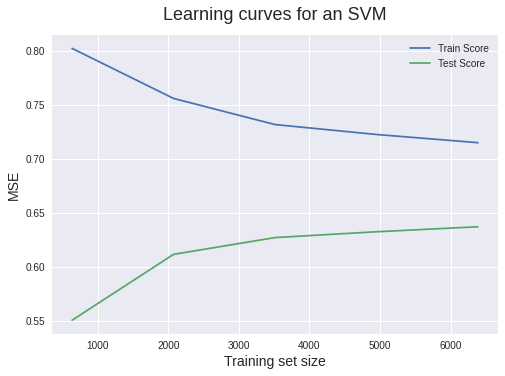

In [ ]:
## plotting learning curve
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for an SVM', fontsize = 18, y = 1.03)
plt.legend(["Train Score", "Test Score"])
plt.show

In [ ]:
print(train_sizes)

[ 638 2075 3512 4949 6387]
